### Pointnet architecture for 3D vision tasks - classification, object detection, segmentation - [article](https://towardsdatascience.com/deep-learning-on-point-clouds-implementing-pointnet-in-google-colab-1fd65cd3a263), [notebook](https://colab.research.google.com/github/nikitakaraevv/pointnet/blob/master/nbs/PointNetClass.ipynb)

### Imports

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import IPython.core.debugger as db
import numpy as np
import math
import random
import os
from pathlib import Path
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

### Download data - 3D ModelNet from Princeton 3D Shapenet
Dataset consists of .off files, containing the description of the composing polygons of geometric objects. They contain meshes represented by vertices and triangular faces, which are formed by 3 vertex indices. It contains 10 classes, 3,991 items for training and 908 for testing.

In [3]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
!unzip -q ModelNet10.zip
!ls ModelNet10  

--2020-08-20 06:15:04--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.61
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.61|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  14.4MB/s    in 34s     

2020-08-20 06:15:39 (13.2 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]

bathtub  chair	dresser  night_stand  sofa   toilet
bed	 desk	monitor  README.txt   table


In [4]:
path = Path("ModelNet10")
list(path.iterdir())

[PosixPath('ModelNet10/night_stand'),
 PosixPath('ModelNet10/bathtub'),
 PosixPath('ModelNet10/chair'),
 PosixPath('ModelNet10/sofa'),
 PosixPath('ModelNet10/monitor'),
 PosixPath('ModelNet10/desk'),
 PosixPath('ModelNet10/README.txt'),
 PosixPath('ModelNet10/dresser'),
 PosixPath('ModelNet10/.DS_Store'),
 PosixPath('ModelNet10/toilet'),
 PosixPath('ModelNet10/bed'),
 PosixPath('ModelNet10/table')]

In [5]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

### Load data

**Read .off files**

In [6]:
# The data is in mesh format in .off files

def read_off(file):
  # First line is the header: 'OFF\n'
  if 'OFF' != file.readline().strip():
    raise('Not a valid OFF header')

  # Second line is '<num vertices> <num faces> <>' eg. '2095 1807 0\n'
  n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])

  # Next 'n_verts' lines are vertices with (x, y, z) coords eg. '30.000000 -35.027505 -12.250000\n'
  # 'verts' is a list of lists. Length is 'n_verts'. Each sublist is one vertex of length 3 coords eg. [[30.0, -35.027505, -12.25], [30.0, -41.027505, -12.25], ...]'
  verts = [[float(s) for s in file.readline().strip().split(' ')] for _ in range(n_verts)]

  # Next 'n_faces' lines are faces with indices of vertices for each face '<num vertices in face> <vertex 1 index> <vertex 2 index> <vertex 3 index>' eg. '3 9 8 11\n'
  # 'faces' is a list of lists. Length is 'n_faces'. Each sublist is one face of length 3 vertex indices eg. [[4, 5, 6], [5, 4, 7], ...]'
  faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for _ in range(n_faces)]

  return verts, faces

In [7]:
with open(path/"bed/train/bed_0001.off", 'r') as f:
  verts, faces = read_off(f)

i,j,k = np.array(faces).T
x,y,z = np.array(verts).T

### Visualise 3D object

In [8]:
# ----------------------------------
# Plotly basic concepts
# The data parameter is a list object in Python. It is a list of all the traces that you wish to plot.
# A trace is a collection of data which is to be plotted. A trace object is named according to how you 
# want the data displayed on the plotting surface.
# A Mesh3d trace is a graph object returned by go.Mesh3D(x, y, z). x, y and z are a list or array object.
# A layout object defines the appearance of the plot, and plot features which are unrelated to 
# the data like the title, axis titles, annotations, legends, spacing, font and even draw 
# shapes on top of the plot.
# A plot is represented by a Figure object created by go.Figure(). It is a dictionary-like object that 
# contains both the data object and the layout object. The figure object is eventually plotted.
# ----------------------------------

def kd_3d(x,y,z,i,j,k):
  # Create the Trace object
  if (i is not None):
    data = [go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i,j=j,k=k)]
  else:
    data = [go.Scatter3d(x=x, y=y, z=z, mode='markers')]
  fig = kd_visualize_rotate(data)

  # Display the figure
  fig.show()

def kd_visualize_rotate (data):
  # Create the Layout and Figure objects
  layout = go.Layout(title = '3D Mesh')
  fig = go.Figure(data = data, layout = layout)

  # Update some parameters
  fig.update_traces(marker=dict(size=2, line=dict(width=2, color='DarkSlateGrey')), selector=dict(mode='markers'))
  return fig

In [9]:
# Visualise the mesh - Vertices and Faces. Confirm that it looks like a bed
kd_3d(x,y,z,i,j,k)

In [10]:
# Visualise just the vertices (without faces) as a scatter plot
# This doesn't look like a bed at all!
# So we can't use the vertices alone as the points for a Point Cloud
kd_3d(x,y,z, None, None, None)

### Generate Point Cloud from Mesh by sampling points on each Face

In [11]:
# Our source dataset is in Mesh format, but we need it as a Point Cloud. As seen
# in the visualisation above, we cannot simply take the vertices and use them as
# the points for the Point Cloud since the vertex points are only at the corners
# of the faces, and there are no points on the flat surface of the faces. Therefore we 
# now have to generate those points on each face.

# To do this we randomly generate points that would like on the flat plane of each
# surface using 3D coordinate geometry. We want more points on the large faces. So
# we assign weights to each face in proportion to its area, and then use that as the
# probability of generating a point on that face. Remember that each face is a triangle.

# Sample points on the object surface uniformly.
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    # Compute the area of a triangular face.
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    # Generate a point randomly on a face, given the vertices of that face.
    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        # Get the input vertices and faces
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        # Compute the areas of each face
        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
        
        # Randomly select a fixed-length list of faces. The probability of selecting
        # a face is proportional to its area.
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        # For each randomly selected face in the list, randomly generate a point
        # that lies somewhere on the surface plane of that face
        sampled_points = np.zeros((self.output_size, 3))
        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points
    

In [12]:
# Now we have points all over the surface of the object. We see that it looks like a
# bed now. We can now use these points as our Point Cloud.
pointcloud = PointSampler(3000)((verts, faces))
pcx, pcy, pcz = pointcloud.T
kd_3d(pcx, pcy, pcz, None, None, None)

### Normalise points

In [13]:
# The objects in the dataset can have different sizes and can be placed in different 
# parts of our coordinate system. So, let’s translate the object to the origin by 
# subtracting mean from all its points and normalizing its points into a unit sphere.

class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [14]:
# Points on the X, Y and Z axis now lie between -1 and 1
norm_pointcloud = Normalize()(pointcloud)
npcx, npcy, npcz = norm_pointcloud.T
kd_3d(npcx, npcy, npcz, None, None, None)

### Augmentation - rotate points and add noise

In [15]:
# To augment the data during training, we randomly rotate objects around Z-axis and 
# add Gaussian noise

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        # Matrix multiplication results in a linear coordinate geometry transform
        # to rotate all the points
        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        # Add some randomly generated noise to each point
        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [16]:
# Points now hae some noise as well
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)
nrpcx, nrpcy, nrpcz = noisy_rot_pointcloud.T
kd_3d(nrpcx, nrpcy, nrpcz, None, None, None)

### Pytorch Tensor

In [17]:
# Create Pytorch tensor from numpy array of points

class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

ToTensor()(noisy_rot_pointcloud)

tensor([[-0.7365, -0.5867,  0.0034],
        [ 0.1713, -0.2058,  0.1183],
        [ 0.1718, -0.1071,  0.1266],
        ...,
        [ 0.4088,  0.1920, -0.2056],
        [ 0.2922,  0.3388,  0.0600],
        [-0.7467,  0.2642, -0.1422]], dtype=torch.float64)

### Create Pytorch Dataset

In [18]:
# Validation Transforms
def default_transforms():
  return transforms.Compose([
                      PointSampler(1024),
                      Normalize(),
                      ToTensor()
                    ])
    
# Training Transforms
train_transforms = transforms.Compose([
                      PointSampler(1024),
                      Normalize(),
                      RandRotation_z(),
                      RandomNoise(),
                      ToTensor()
                    ])

In [19]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        # One class per sub-folder
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}

        # List of transforms
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []

        # Read all the data files contained in each sub-folder per object class
        # Create a dictionary of all the data file names along with the class name
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    # Load the Point Cloud data for one object by reading the data file and applying transforms
    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        # Get the file name and class for the item index
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']

        # Read the file and apply all the transforms
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        
        # return the point cloud data for that file
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [20]:
# Create the Training and Validation Datasets
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [21]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [22]:
# Create the Training and Validation Data Loaders
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

### Model - Classification only. Can extend for Detection and Segmentation

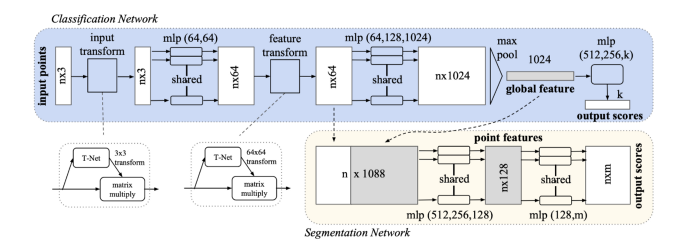

In [23]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

# Our tensors will have size (batch_size, num_of_points, 3). In this case MLP with shared weights is just 
# a 1-dim convolution with a kernel of size 1. To ensure invariance to transformations, we apply the 
# 3x3 transformation matrix predicted by T-Net to coordinates of input points. For initialisation of the 
# output matrix, we want it to be identity by default to start training with no transformations at all. 
# So, we just add an identity matrix to the output

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix

# We will use the same but 64-dim T-Net to align extracted point features after 
# applying MLP. To provide permutation invariance, we apply a symmetric function (max pooling) to 
# the extracted and transformed features so the result does not depend on the order of 
# input points anymore.

class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

# wrap it all in one class with the last MLP and LogSoftmax at the output
class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [24]:
# Define the loss function. As we used LogSoftmax for stability, we should apply NLLLoss 
# instead of CrossEntropyLoss. Also, we will add two regularization terms in order 
# transformations matrices to be close to orthogonal ( AAᵀ = I )

def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

### Training

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [26]:
pointnet = PointNet()
pointnet.to(device);

In [27]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [28]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    # Loop through epochs
    for epoch in range(epochs): 
        # Put model in training mode
        pointnet.train()
        running_loss = 0.0

        # Loop through each training batch
        for i, data in enumerate(train_loader, 0):
            # Get the 'x' inputs and 'y' labels and generate predictions
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            # Compute loss and back-propagate
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        # Put the model in eval mode for validation
        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                # Loop through the validation batches
                for data in val_loader:
                    # Get 'x' inputs and 'y' labels and generate predictions
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))

                    # Predicted class is the class with the highest score
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    # Number of correct predictions
                    correct += (predicted == labels).sum().item()
            # Track accuracy
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "save_"+str(epoch)+".pth")

In [29]:
train(pointnet, train_loader, valid_loader, epochs=15, save=False)

[Epoch: 1, Batch:   10 /  125], loss: 2.041
[Epoch: 1, Batch:   20 /  125], loss: 1.594
[Epoch: 1, Batch:   30 /  125], loss: 1.511
[Epoch: 1, Batch:   40 /  125], loss: 1.315
[Epoch: 1, Batch:   50 /  125], loss: 1.197
[Epoch: 1, Batch:   60 /  125], loss: 1.104
[Epoch: 1, Batch:   70 /  125], loss: 1.123
[Epoch: 1, Batch:   80 /  125], loss: 0.973
[Epoch: 1, Batch:   90 /  125], loss: 1.043
[Epoch: 1, Batch:  100 /  125], loss: 0.901
[Epoch: 1, Batch:  110 /  125], loss: 0.988
[Epoch: 1, Batch:  120 /  125], loss: 0.915
Valid accuracy: 62 %
[Epoch: 2, Batch:   10 /  125], loss: 0.889
[Epoch: 2, Batch:   20 /  125], loss: 0.835
[Epoch: 2, Batch:   30 /  125], loss: 0.876
[Epoch: 2, Batch:   40 /  125], loss: 0.863
[Epoch: 2, Batch:   50 /  125], loss: 0.678
[Epoch: 2, Batch:   60 /  125], loss: 0.780
[Epoch: 2, Batch:   70 /  125], loss: 0.817
[Epoch: 2, Batch:   80 /  125], loss: 0.689
[Epoch: 2, Batch:   90 /  125], loss: 0.832
[Epoch: 2, Batch:  100 /  125], loss: 0.565
[Epoch: 2, 

## Test - generate predictions and confusion matrix

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
# Use the model that was trained above (since we are not saving the model)

#pointnet = PointNet()
#pointnet.load_state_dict(torch.load('save.pth'))
pointnet.eval();

In [32]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.cpu().numpy())
        all_labels += list(labels.cpu().numpy())
        


Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]


In [33]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[38,  9,  1,  0,  0,  0,  0,  2,  0,  0],
       [ 0, 93,  1,  0,  0,  1,  0,  2,  3,  0],
       [ 0,  1, 99,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4, 49,  3,  0,  2, 12, 16,  0],
       [ 0,  0,  3,  1, 68,  1, 12,  0,  1,  0],
       [ 0,  0,  2,  0,  4, 90,  4,  0,  0,  0],
       [ 0,  0,  4,  2, 21,  0, 55,  0,  4,  0],
       [ 0,  3,  1,  0,  0,  0,  1, 95,  0,  0],
       [ 0,  0,  0, 16,  0,  0,  0,  0, 84,  0],
       [ 0,  0, 18,  1,  1,  2,  6,  0,  0, 72]])

In [34]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<Figure size 576x576 with 0 Axes>

Normalized confusion matrix


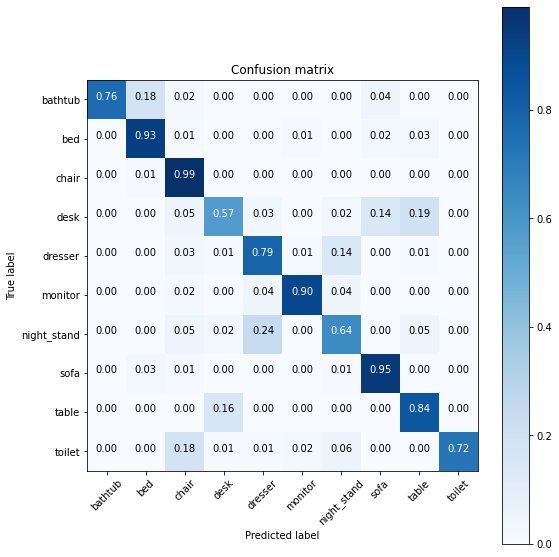

In [35]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

<Figure size 576x576 with 0 Axes>

Confusion matrix, without normalization


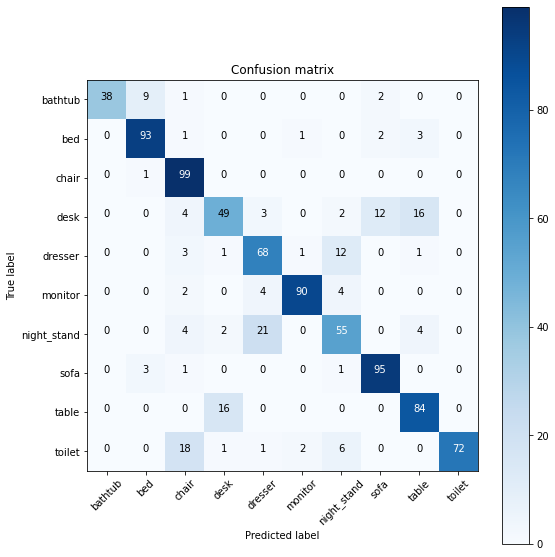

In [36]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)